# Analyzing player behavior to predict usage of a Minecraft research server

## Introduction

### Background

Minecraft is a sandbox, open-world video game developed by Mojang Studios where players explore, build and interact in a three-dimensional virtual world made of blocks. Players can build structures, gather resources and craft items to aid their survival, either individually or with other players in a multiplayer server (Minecraft.net, 2023). This makes it an ideal platform for studying player behaviors in a video game.

A research group led by Professor Frank Wood wants to assess how people play video games. To do this, they have set up a Minecraft server where players' interactions are recorded in detailed session logs. However, in doing so they face challenges such as identifying which players are most valuable to recruit and ensuring they have the resources necessary. Understanding period where most sessions are played is crucial in maintaining the scale of the research and minimizing the cost. Different time periods may contribute to the different amount of data, which leads to requiring levels of technical support, and placing different demands on valuable resources during those time periods. By identifying the different time periods through clustering analysis, research teams can ensure adequate resource management.

### Question

This project aims to answer the question: **What times of day tend to have the most simultaneous players, and can we identify daily patterns in player activity to forecast demand?**

### Data Description

We will be using the `sessions.csv` dataset provided by the research group to determine which time periods most valuable to optimize the resource management and ensure they have the resources necessary. 

The dataset is structured as follows:

1. `hasedEmail`: encrypted email for each player
2. `start_time`: start time of session
3. `end_time`: end time of session
4. `original_start_time`: computer tracked start time (number of seconds from Jan 1 1970)
5. `original_end_time`: computer tracked end time (number of seconds from Jan 1 1970)

This dataset contains **1535** unique sessions.

## Methods & Result

### Load data and wrangle data

1. To begin analysis, we need to load all the necessary libraries and import the datasets. Load the `sessions.csv` data and assign it to the object `sessions` using `read_csv`. Since we won't be using the original times and hasedEmail, we can remove those columns.
2. We need to parse the data from the dataset into the approproiate time format which is `day/month/year hour:minute`. We also need to seperate the session start times and end times into their respective day of the week and hour of the day. Some session duration may be 0 so we have to filter these out too.
3. Count how many sessions start in each hour across all days.

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(tidyclust)
options(repr.matrix.max.rows = 6)

sessions <- read.csv("data/sessions.csv") |> select(start_time, end_time)
head(sessions)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

,start_time,end_time
,<chr>,<chr>
1,30/06/2024 18:12,30/06/2024 18:24
2,17/06/2024 23:33,17/06/2024 23:46
3,25/07/2024 17:34,25/07/2024 17:57
4,25/07/2024 03:22,25/07/2024 03:58
5,25/05/2024 16:01,25/05/2024 16:12
6,23/06/2024 15:08,23/06/2024 17:10


In [5]:
sessions_clean <- sessions |>
  mutate(start_time = dmy_hm(start_time)) |>
  mutate(hour = hour(start_time)) |>
  drop_na(hour)
sessions_clean

sessions_per_hour <- sessions_clean |>
  group_by(hour) |>
  summarise(num_sessions = n()) |>
  ungroup()
sessions_per_hour

start_time,end_time,hour
<dttm>,<chr>,<int>
2024-06-30 18:12:00,30/06/2024 18:24,18
2024-06-17 23:33:00,17/06/2024 23:46,23
2024-07-25 17:34:00,25/07/2024 17:57,17
⋮,⋮,⋮
2024-07-28 15:36:00,28/07/2024 15:57,15
2024-07-25 06:15:00,25/07/2024 06:22,6
2024-05-20 02:26:00,20/05/2024 02:45,2


hour,num_sessions
<int>,<int>
0,128
1,79
2,152
⋮,⋮
21,91
22,89
23,122


### Summarizing and Visualizing
1. We can summarize the wrangled data to see if there any reccuring obvious patterns and distributions such as what time of day do most people play at simultaneously.
2. View this summary through a visualization.

In [6]:
sessions_per_hour <- sessions_clean |>
  group_by(hour) |>
  summarise(num_sessions = n()) |>
  ungroup() |>
    arrange(desc(num_sessions))
sessions_per_hour

hour,num_sessions
<int>,<int>
2,152
4,151
3,131
⋮,⋮
10,3
13,2
12,1


ERROR: [1m[33mError[39m in `group_by()`:[22m
[1m[22m[33m![39m Must group by variables found in `.data`.
[31m✖[39m Column `start_time_day` is not found.


From the summary tables, we can see that the largest sum of players play at around 2 AM with the least at 12 PM.

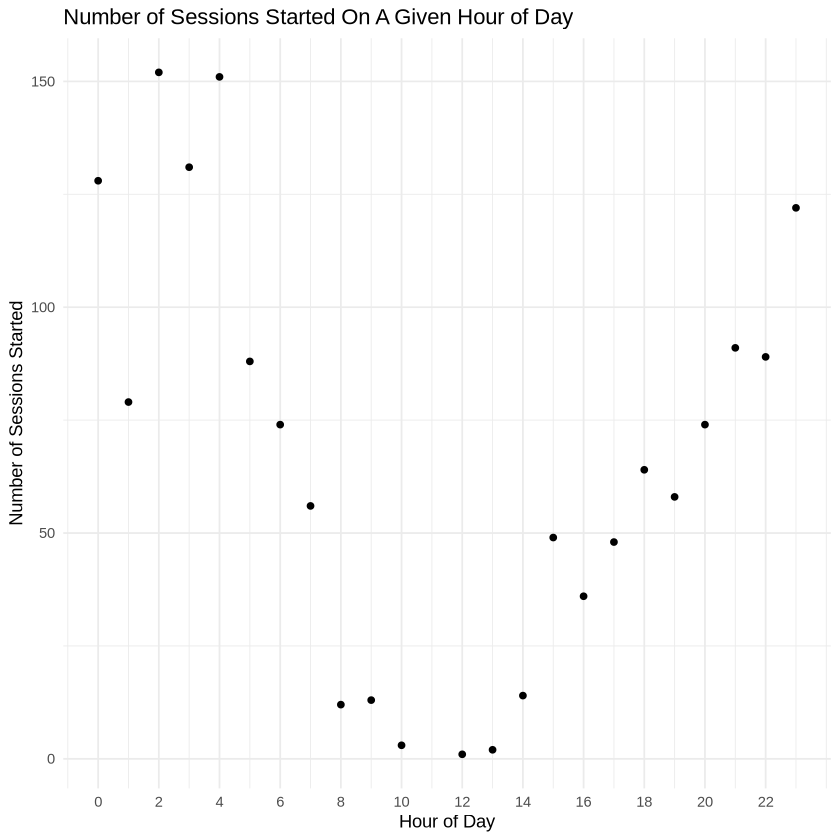

In [9]:
scatter_cluster_plot <- sessions_per_hour |>
  ggplot(aes(x = hour, y = num_sessions)) +
  geom_point() +
  scale_x_continuous(breaks = seq(0, 23, by = 2)) +
  labs(title = "Number of Sessions Started On A Given Hour of Day",
       x = "Hour of Day", y = "Number of Sessions Started") +
  theme_minimal()
scatter_cluster_plot

This plot shows when longer and shorter sessions tend to occur, helping us assess demand at different times of the day. For instance, longer sessions may cluster during late nights/early mornings or early/late evenings.

### Clustering Analysis

1. We need to scale and center before using K-means clustering because since it uses Euclidean distance otherwise, variables with larger numeric ranges (number of sessions) will dominate the clustering.
2. Since we don’t know the best number of clusters, for `num_clusters` parameter, we use `tune()`. This allows us to try different values and choose the best one based on within cluster sum-of-squares distance (WSSD).
3. Build a workflow, then we tune the model for different number of clusters `k` to find the best value of `k`. We can visualize the best value of `k` by plotting each value to their WSSD.
4. After finding the best value for `k`, we can find and visualize the clusters to interpret player behavior or demand patterns.

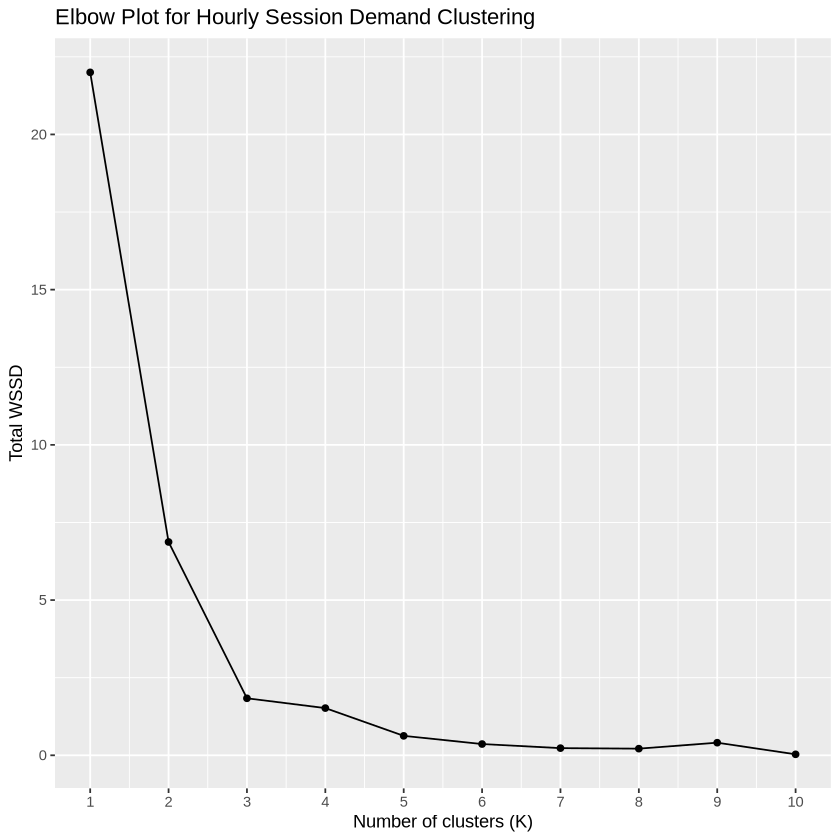

In [17]:

recipe <- recipe(~ num_sessions, data = sessions_per_hour) |>
  step_center(all_predictors()) |>
  step_scale(all_predictors())

model_spec <- k_means(num_clusters = tune()) |>
  set_engine("stats")

k_values <- tibble(num_clusters = 1:10)

elbow_stats <- workflow() |>
  add_recipe(recipe) |>
  add_model(model_spec) |>
  tune_cluster(resamples = apparent(sessions_per_hour), grid = k_values) |>
  collect_metrics() |>
  filter(.metric == "sse_within_total") |>
  mutate(total_WSSD = mean) |>
  select(num_clusters, total_WSSD)

# Step 6: Elbow Plot
elbow_plot <- elbow_stats |>
  ggplot(aes(x = num_clusters, y = total_WSSD)) +
  geom_point() +
  geom_line() +
scale_x_continuous(breaks = seq(1, 10, by = 1)) +
  labs(x = "Number of clusters (K)", y = "Total WSSD",
       title = "Elbow Plot for Hourly Session Demand Clustering")
elbow_plot

From this elbow plot, we look for the “elbow point” to choose an optimal number of clusters. In this example, we can see that the most suitable number of clusters is `k` = 2 because as we increase the number of clusters, the WSSD decreases very slightly.

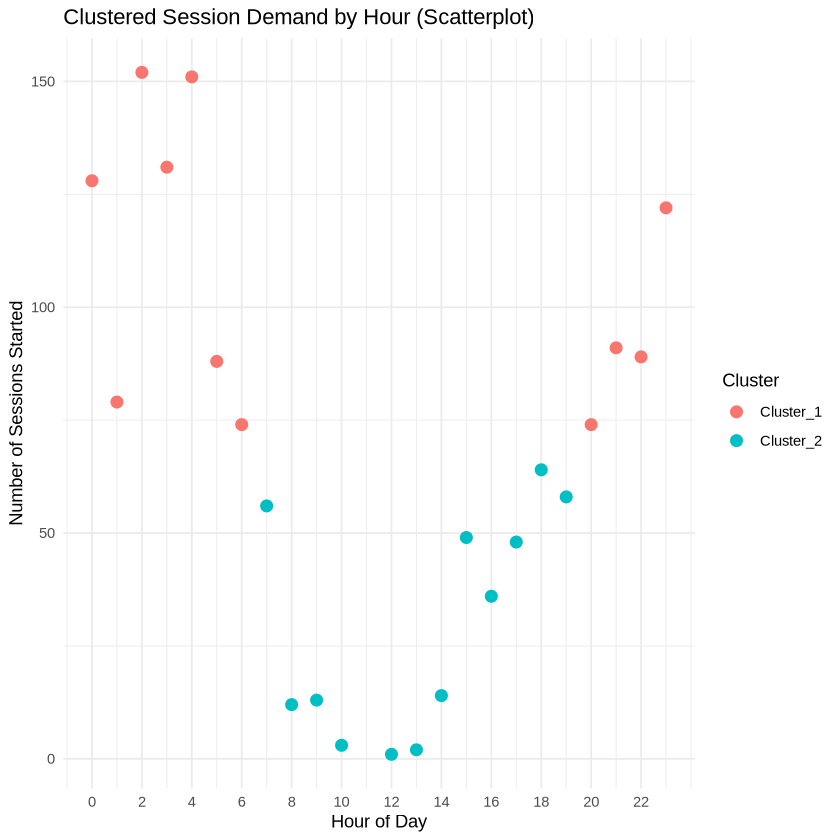

In [16]:
final_model <- k_means(num_clusters = 2) |>
  set_engine("stats")

final_workflow <- workflow() |>
  add_recipe(recipe) |>
  add_model(final_model) |>
  fit(data = sessions_per_hour)

sessions_clustered <- final_workflow |>
  augment(new_data = sessions_per_hour)

scatter_cluster_plot <- sessions_clustered |>
  ggplot(aes(x = hour, y = num_sessions, color = .pred_cluster)) +
  geom_point(size = 3) +
  scale_x_continuous(breaks = seq(0, 23, by = 2)) +
  labs(title = "Clustered Session Demand by Hour (Scatterplot)",
       x = "Hour of Day", y = "Number of Sessions Started",
       color = "Cluster") +
  theme_minimal()
scatter_cluster_plot

This visualization allows us to interpret cluster patterns. We can see that there are 2 distinct clusters, one indicating the high demand period where at hours 0-7 and 21-23 consistently show high session counts and the other indicating low demand period where at hours 8-20 show low session counts.

## Discussion

### Summary of Findings

The question that we were trying to answer was: “**What times of day tend to have the most simultaneous players, and can we identify daily patterns in player activity to forecast demand?**”. Clustering the hourly session counts using k-means clustering to identify periods of high and low demand throughout the day, this revealed two distinct clusters:
- One cluster consisted of early morning and late evening hours (0-7 and 21-23), which consistently had high session activity with the peak being at 2 of 150 sessions per hour.
- The other cluster included daytime to early night hours (8-20), with significantly lower session counts.

These clusters suggest that players tend to log on during 2 distinct time windows, supporting the idea that time-of-day is a strong predictor of session behavior.

### Was This Expected?

While it’s common to assume peak usage would occur during the day or afternoon, this result was somewhat surprising. The late-night and early-morning activity peaks may reflect the habits of night-active players possibly due to night owns or those in other time zones. As for the clear low-demand window, this likely due to players at work or simply at school. In conclusion, this finding shows behavioral insights about the player base where they tend to be active during work hours and more active during nighttime which could reflect students, nightowls or international participants.

### Potential Impact of Findings

These results can help the research group at UBC optimize server resource allocation by increasing server capacity and license availability during peak demand hours, and scaling down during low-demand periods. It also informs targeted recruitment strategies, suggesting that recruitment might be more effective and efficient if aligned with active time windows (late nights and early mornings). Additionally, scheduling maintenance or updates can be planned during the low-demand hours between minimize user disruption.

### Future Questions Raised

1. How does demand change across days of the week or over months?
2. What is the demographic of players during each periods? Are players during high-demand periods mostly students or international users playing?
3. Can session patterns be predicted more precisely with additional player information such as age, region, experience level?
4. Does session length differ by time of day?

## References

Landin, Per. “What is Minecraft.” Minecraft.net, 5 June 2023, www.minecraft.net/en-us/article/what-minecraft.

